In [1]:
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt, numpy as np, pandas as pd

def ber(p, shape):
  return (np.random.uniform(size = shape) < p).astype(int)

# Q1

### b)

First, $\newcommand{\E}{\mathbb{E}}\newcommand{\V}{\text{Var}}\begin{bmatrix} p_0 & \dots & p_0 \\ p_1 & \dots & p_M \end{bmatrix}$ becomes $\bar X=\begin{bmatrix} 0 & \dots & 0 \\ p_1-p_0 & \dots & p_M-p_0 \end{bmatrix}$ by substracting the first row from the second row. Then,\begin{align*}
  \bar K=\frac{1}{M}\bar X\bar X^T=\frac{1}{M}\begin{bmatrix} 0 & \dots & 0 \\ p_1-p_0 & \dots & p_M-p_0 \end{bmatrix}\begin{bmatrix} 0 & p_1-p_0 \\ \vdots & \vdots \\ 0 & p_M-p_0 \end{bmatrix}=\begin{bmatrix} 0 & 0 \\ 0 & \frac{1}{M}\sum_{i=1}^M(p_i-p_0)^2 \end{bmatrix}
\end{align*}where the eigenvalues are $0$ and $\frac{1}{M}\sum_{i=1}^M(p_i-p_0)^2$ since $\bar K$ is a diagonal matrix. Since $\E[p_i]=p_0$ and $\V(p_i)=\V(p_j)\approx\frac{tp_0(1-p_0)}{2N}$ for $i\neq j$, the expected value of the largest eigenvalue is\begin{align*}
  \E[\lambda_1]=\E[\frac{1}{M}\sum_{i=1}^M(p_i-p_0)^2]=\frac{1}{M}\sum_{i=1}^M\E[(p_i-p_0)^2]=\frac{1}{M}\sum_{i=1}^M\V(p_i)\approx\frac{tp_0(1-p_0)}{2N}
\end{align*}by the linearity of expectation, while the corresponding eigenvector is $\begin{bmatrix} 0 & 1 \end{bmatrix}^T$.

### c)

The observed and expected eigenvalues are largely similar in the plot below, except for a noticeable deviation between them for $t$ close to $0$.

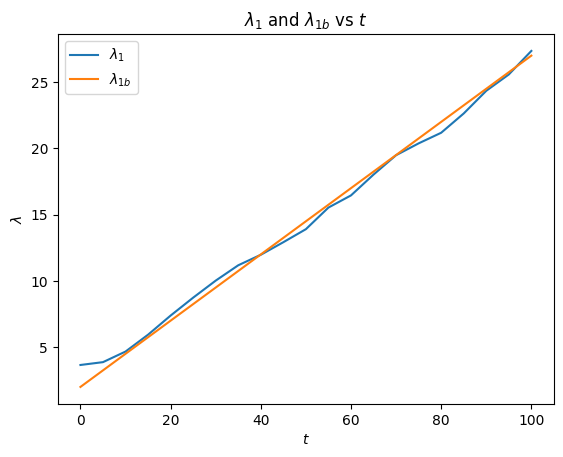

In [16]:
def sim_1(p_0, N, M, t):
  e_1, dims = [], (2 * N, M)
  derived = ber(p_0, dims)
  source = ber(p_0, dims)

  for i in range(t + 1):
    X = np.concatenate((derived, source), axis = 0) - p_0
    if i % 5 == 0: e_1.append(np.max(eigsh(X @ X.T / M)[0]))
    freqs = np.mean(derived, axis = 0)
    if i < t: derived = ber(freqs, dims)

  return e_1

t = 100; x = np.arange(t + 1)
lambda_1 = sim_1(0.5, 1000, 500, t)
plt.plot(x[::5], lambda_1, label = r'$\lambda_1$')
plt.plot(x, x / 4 + 2, label = r'$\lambda_{1b}$')
plt.title(r"$\lambda_1$ and $\lambda_{1b}$ vs $t$")
plt.xlabel(r"$t$"); plt.ylabel(r"$\lambda$")
plt.legend(); plt.show()

### d)

$F_{st}$ depends on $m$ since a larger migration rate allows the sharing of genetic information, which mitigates genetic drift and thus the genetic difference between the populations. $F_{st}$ also depends on $N$ since a smaller derived population is likely to experience more genetic drift, which increases its genetic difference with the source population. Both phenomena can be observed in the plot below.

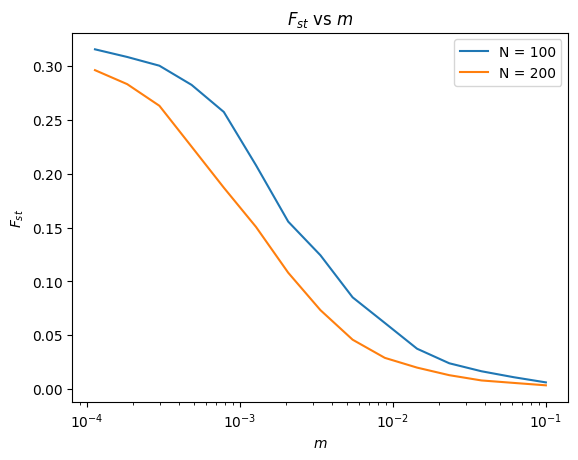

In [6]:
def sim_2(p_0, N, M, r_s):
  lst = []
  dims = (2 * N, M)
  derived = ber(p_0, dims)

  for r in r_s:
    for i in range(2 * N + 1):
      freqs_2 = np.mean(derived, axis = 0)
      derived = ber(r * p_0 + (1 - r) * freqs_2, dims)
    lst.append(np.mean((p_0 - freqs_2) ** 2) / np.mean((p_0 + freqs_2) * (2 - p_0 - freqs_2)))

  return lst

x, N_s = np.logspace(-5, -1, 20), [100, 200]
plt.plot(x[5:], sim_2(0.5, N_s[0], 500, x)[5:], label = f'N = {N_s[0]}')
plt.plot(x[5:], sim_2(0.5, N_s[1], 500, x)[5:], label = f'N = {N_s[1]}')
plt.title(r'$F_{st}$ vs $m$'); plt.xlabel(r'$m$'); plt.ylabel(r'$F_{st}$')
plt.xscale('log'); plt.legend(); plt.show()

### e)

Repeating the simulation three times, the relative positions of the population means and haplotypes are different for each plot. However, the derived population with $2N_1=200$ is farther from the source population in all the plots. This makes sense since a smaller population is likely to experience more genetic drift.

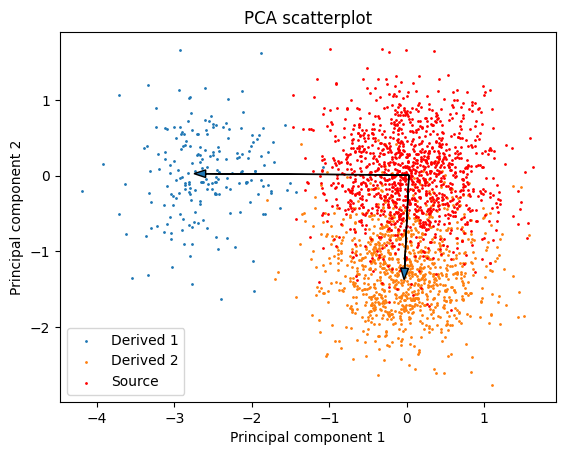

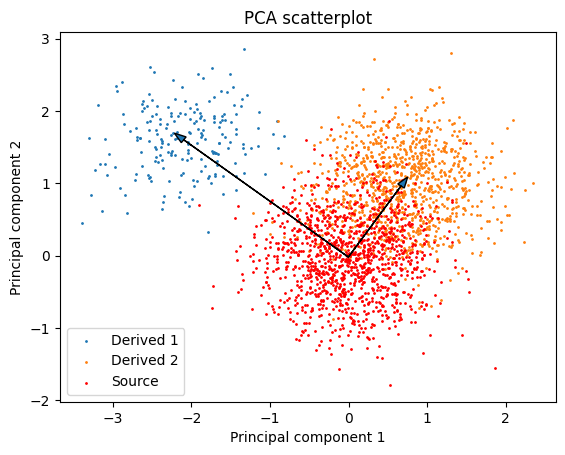

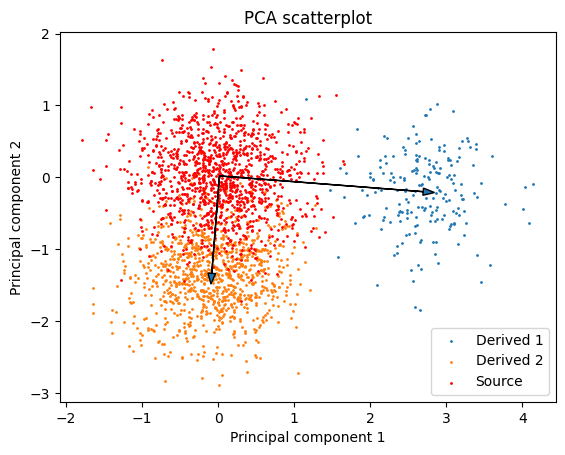

In [13]:
def sim_3(p_0, a, b, M, t, r = 0):
  derived_1 = ber(p_0, (a, M))
  derived_2 = ber(p_0, (b, M))
  source = ber(p_0, (a + b, M))

  for i in range(t + 1):
    freqs_1 = np.mean(derived_1, axis = 0)
    freqs_2 = np.mean(derived_2, axis = 0)
    derived_1 = ber((1 - r) * freqs_1 + r * freqs_2, (a, M))
    derived_2 = ber(r * freqs_1 + (1 - r) * freqs_2, (b, M))

  X = np.concatenate((derived_1, derived_2, source), axis = 0) - p_0
  df = X @ eigsh(X.T @ X / M, k = 2, which = 'LM')[1]
  df_1, df_2, df_3 = df[:a, :], df[a:a + b, :], df[a + b:, :]
  m_1, m_2, m_3 = np.mean(df_1, axis = 0), np.mean(df_2, axis = 0), \
    np.mean(df_3, axis = 0)

  plt.scatter(*df_1.T, label = 'Derived 1', s = 1)
  plt.scatter(*df_2.T, label = 'Derived 2', s = 1)
  plt.scatter(*df_3.T, label = 'Source', s = 1, c = 'red')
  plt.arrow(*m_3, *(m_1 - m_3), head_width = 0.1)
  plt.arrow(*m_3, *(m_2 - m_3), head_width = 0.1)
  plt.title('PCA scatterplot')
  plt.xlabel('Principal component 1'); plt.ylabel('Principal component 2')
  plt.legend(); plt.show()

for _ in range(3): sim_3(0.5, 200, 1000, 500, 10)

### f)

As $t$ increases, both derived populations drift away from the source population, with the smaller derived population drifting more as before. However, with a non-zero migration rate, the derived populations remain relatively close together such that for $t=250$, they are closer to each other than to the source population.



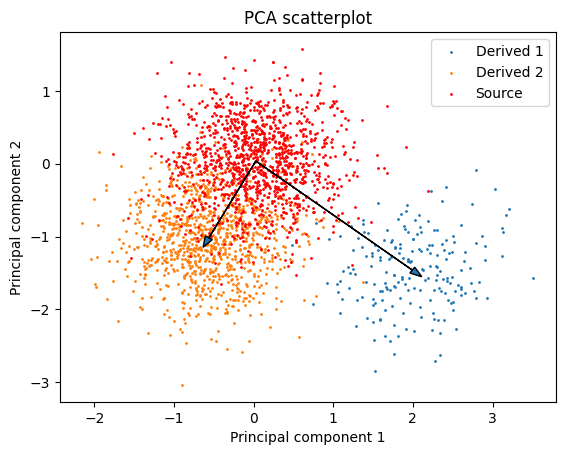

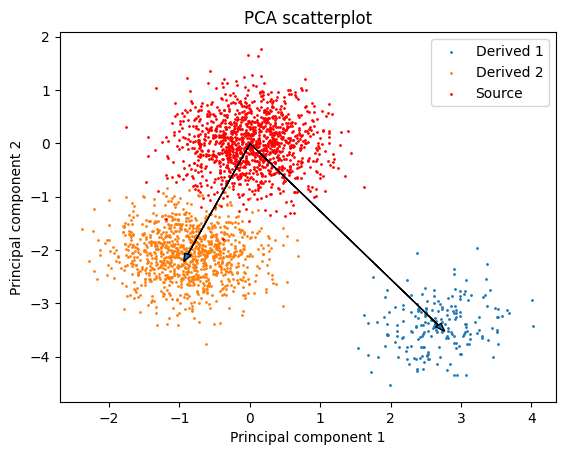

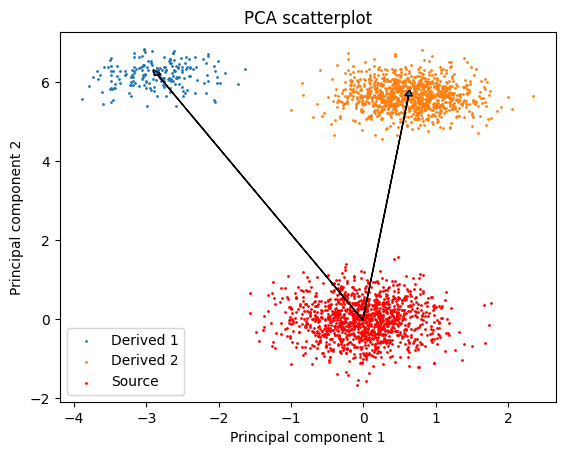

In [ ]:
for t in [10, 50, 250]: sim_3(0.5, 200, 1000, 500, t, 0.01)